A notebook that demonstrates how a single image will be processed with both clustering and deep-learning prediction.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import pipeline
from datasets import load_dataset
import pickle

from utils import imageutils

In [3]:
dataset = load_dataset("e1010101/tongue-images-384-segmented")

# Original Image

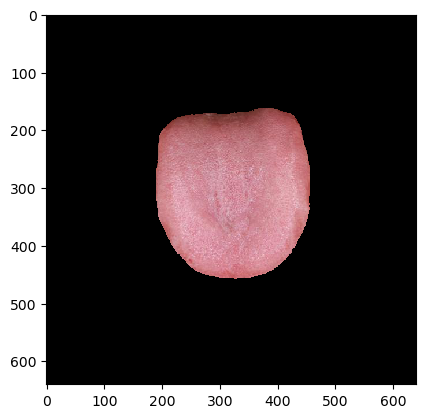

In [4]:
test_image = dataset['train'][0]['image']

plt.imshow(test_image, interpolation='nearest')
plt.show()

In [5]:
# Original Labels - Crack, Red Dots, Toothmark
test_labels = dataset['train'][0]['labels']
test_labels

[0.0, 0.0, 1.0]

# Edge Extraction

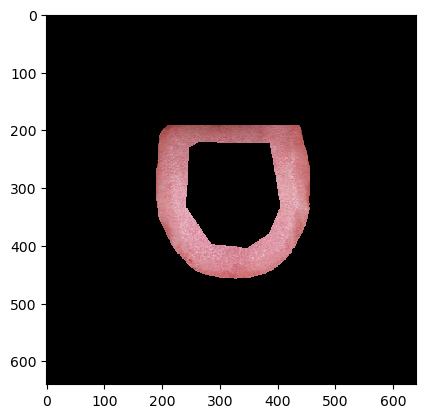

In [6]:
edge_extracted_image = imageutils.extract_edges(np.array(test_image))

plt.imshow(edge_extracted_image, interpolation='nearest')
plt.show()

# K-Means Clustering

In [7]:
def extract_lab_features(image):
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [8]:
l_values = []
a_values = []
b_values = []

In [9]:
l_mean, a_mean, b_mean = extract_lab_features(edge_extracted_image)

l_values.append(l_mean)
a_values.append(a_mean)
b_values.append(b_mean)

In [10]:
with open('checkpoints/kmeans/model.pkl', 'rb') as f:
    kmeans = pickle.load(f)

In [11]:
len(kmeans.cluster_centers_)

6

In [12]:
features = np.array([[a_mean, b_mean]])

# Get cluster prediction
cluster = kmeans.predict(features)[0]
print(f"Image belongs to cluster: {cluster}")

Image belongs to cluster: 5


c:\Users\ezrat\anaconda3\envs\Project\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


The A/B components of the image are closest to cluster 5, as displayed below.

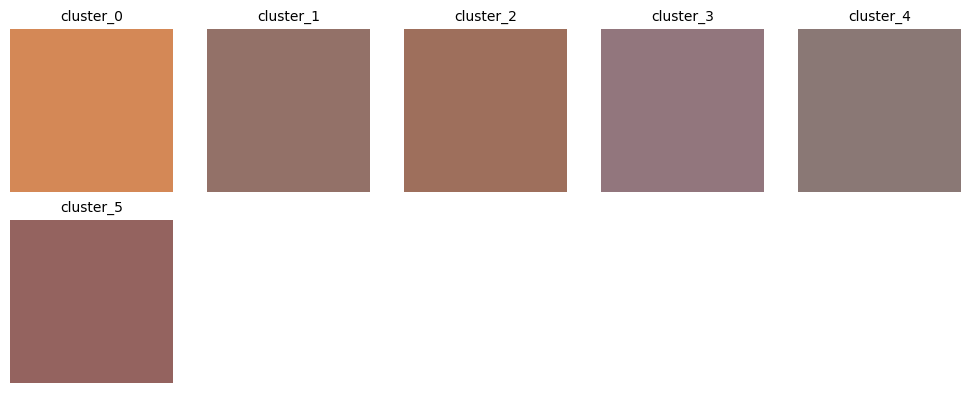

# Binary Multi-Label Classification

In [13]:
classifier = pipeline("image-classification", model="e1010101/vit-384-tongue-image")
classifier(test_image)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'Crack', 'score': 0.5933064222335815},
 {'label': 'Toothmark', 'score': 0.3458491861820221},
 {'label': 'Red-Dots', 'score': 0.060844384133815765}]